Each particle represents 8949.2  atoms
Plotting initial conditions. Close plots to continue.


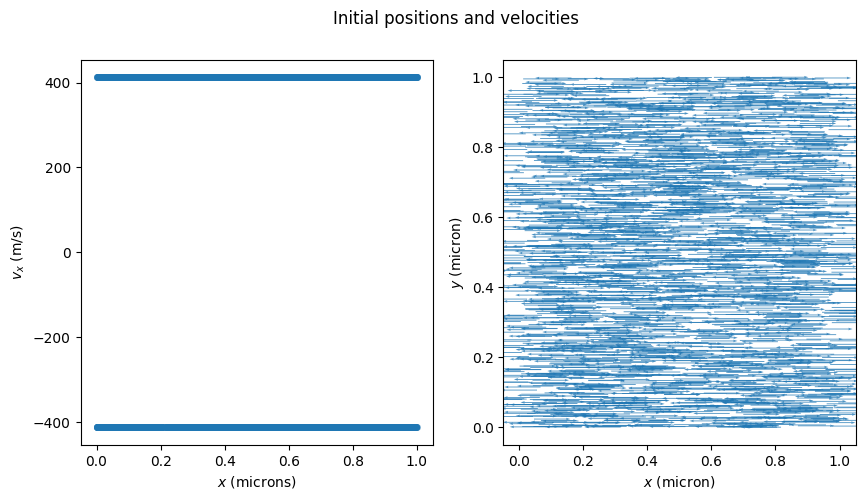

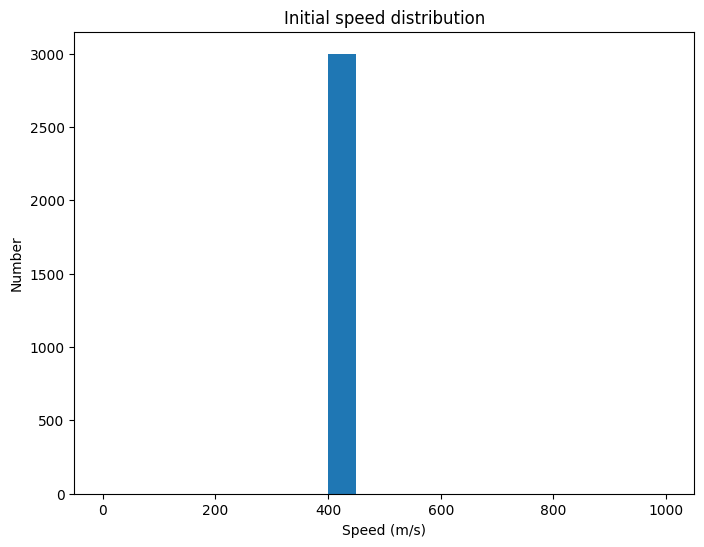

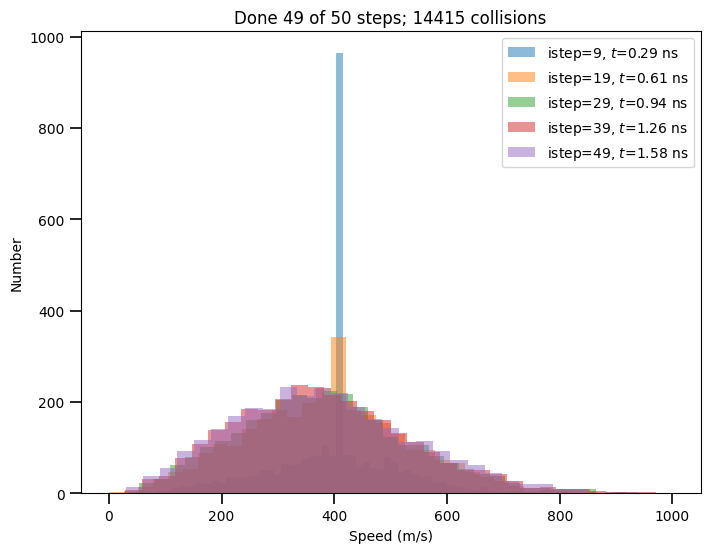

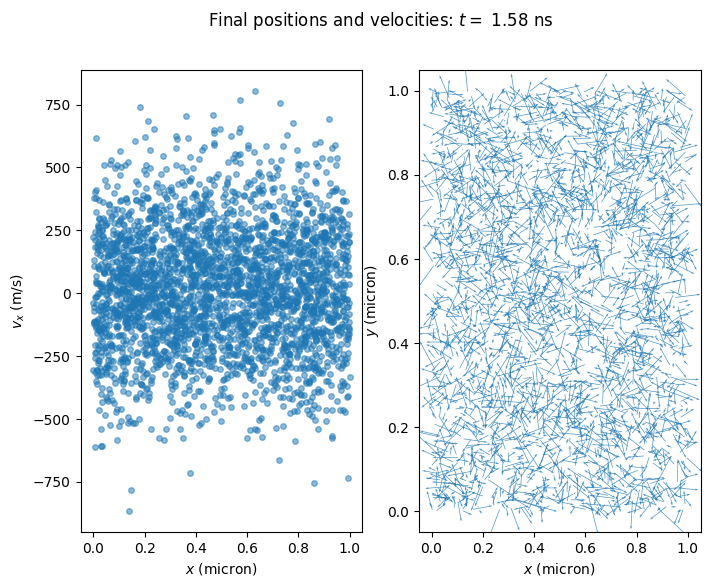

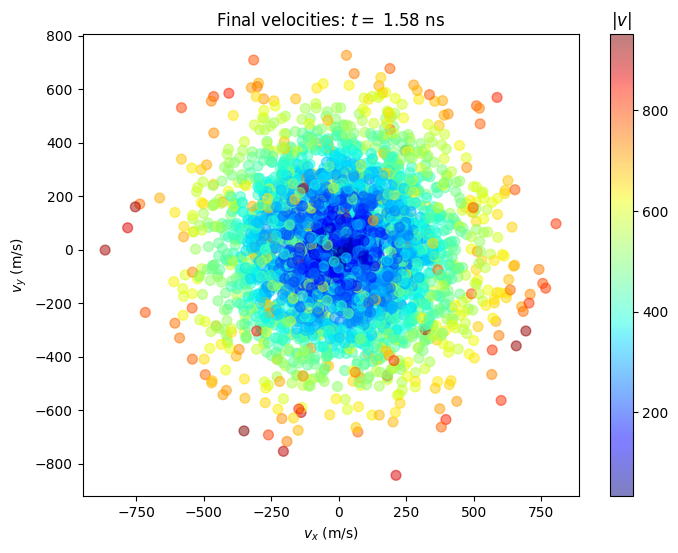

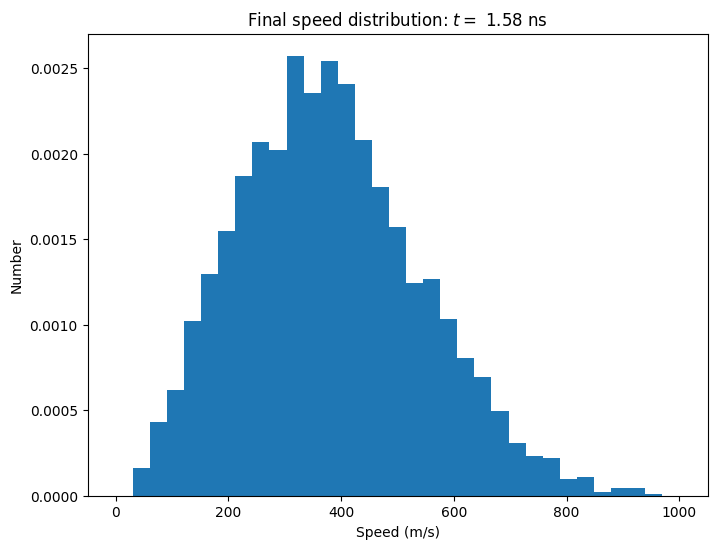

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collider import collider

# plt.style.use('matplotlibrc')  # This means that plots in this script will use the style parameters set in the rc file unless otherwise specified.

# Set up input functions
def dinput(input_text) :
    return int(input(input_text))


def finput(input_text) :
    return float(input(input_text))


# Define classes for dealing with lists of particles
class sortList:
    """Class used for sorting particles into cells."""
    def __init__(self, ncell_in, npart_in):
        self.ncell = ncell_in
        self.npart = npart_in
        self.cell_n = np.zeros(ncell_in, dtype=int)
        self.index = np.empty(ncell_in, dtype=int)
        self.Xref = np.empty(npart_in, dtype=int)


class sampList:
    """Class used for sampling density, velocity, and temperature."""
    def __init__(self, ncell_in):
        self.ncell = ncell_in
        self.nsamp = 0
        self.ave_n = np.zeros(ncell_in)
        self.ave_u = np.zeros((ncell_in,3))
        self.ave_T = np.zeros(ncell_in)


def sorter(x,L,sD) :
    """sorter - Function to sort particles into cells
       Inputs
         x       Positions of particles
         L       System size
         sD      Object containing sorting lists
    """

    #* Find the cell address for each particle
    npart = sD.npart
    ncell = sD.ncell
    jx = np.empty(npart,dtype=int)
    for ipart in range(npart) :
        jx[ipart] = int(x[ipart]*ncell/L)
        jx[ipart] = min(jx[ipart], (ncell-1))

    #* Count the number of particles in each cell
    sD.cell_n = np.zeros(ncell)
    for ipart in range(npart):
        sD.cell_n[jx[ipart]] += 1

    #* Build index list as cumulative sum of the number of particles in each cell
    m = 0
    for jcell in range(ncell) :
        sD.index[jcell] = m
        m += sD.cell_n[jcell]

    #* Build cross-reference list
    temp = np.zeros(ncell, dtype=int)      # Temporary array
    for ipart in range(npart) :
        jcell = jx[ipart]       # Cell address of ipart
        k = sD.index[jcell] + temp[jcell]
        sD.Xref[k] = ipart
        temp[jcell] += 1


#* Initialize constants  (particle mass, diameter, etc.)
boltz = 1.3806e-23     # Boltzmann's constant (J/K)
mass = 6.63e-26        # Mass of argon atom (kg)
diam = 3.66e-10        # Effective diameter of argon atom (m)
T = 273                # Temperature (K)
density = 1.78         # Density of argon at STP (kg/m^3)
L = 1e-6               # System size is one micron
# npart = dinput('Enter number of simulation particles: ')
npart = 3000 # number of simulation particles
eff_num = density/mass * L**3 /npart
print('Each particle represents %.1f  atoms' % eff_num)


#* Assign random positions and velocities to particles
np.random.seed(0)          # Initialize random number generator
# x = np.empty(npart)
x = np.random.random(npart) * L           # Assign random positions
v_init = np.sqrt(3*boltz*T/mass)      # Initial speed in m/s
v = np.zeros((npart,3))  # Initialize vector of 3D velocities. First dimension is the number of particles, second dimension 3 for x, y, z.
v[:,0] = v_init * (1 - 2 * np.floor(2*np.random.random(npart)))  # Initially, only x-component of velocity is non-zero

# Plot initial positions and velocities
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig1.suptitle('Initial positions and velocities')
ax1[0].plot(x/1e-6,v[:,0],'o',ms=4,alpha=0.5)
ax1[0].set_xlabel('$x$ (microns)')
ax1[0].set_ylabel('$v_x$ (m/s)')

ax1[1].quiver(x/1e-6, np.random.random(npart)*L/1e-6,v[:,0],v[:,1],scale_units='width',scale=4000,alpha=0.8,color='C0')
ax1[1].set_xlabel('$x$ (micron)')
ax1[1].set_ylabel('$y$ (micron)')

# Plot the initial speed distribution
fig3, ax3 = plt.subplots(figsize=(8,6))
vmag = np.linalg.norm(v, axis=1)  # find the magnitude of the velocity.
ax3.hist(vmag, bins=20, range=(0,1000))
ax3.set_title('Initial speed distribution')
ax3.set_xlabel('Speed (m/s)')
ax3.set_ylabel('Number')

print('Plotting initial conditions. Close plots to continue.')
plt.show()

#* Initialize variables used for evaluating collisions
ncell = 15                      # Number of cells
dt = 0.2*(L/ncell)/v_init      # Set timestep dt
vrmax = 3*v_init*np.ones(ncell)    # Estimated max rel. speed
selxtra = np.zeros(ncell)          # Used by routine "collider"
coeff = 0.5*eff_num*np.pi*diam**2*dt/(L**3/ncell)
coltot = 0                      # Count total collisions

# Declare sortList object for lists - used in sorting
sortData = sortList(ncell, npart)

############# MAIN LOOP ##################################
# * Loop for the desired number of time steps
# nstep = dinput('Enter total number of time steps: ')
nstep = 50

fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.tick_params('both', length=8, width=1.2, which='major')  # bigger axis ticks

for istep in range(nstep):

    # * Move all the particles ballistically
    x = x + v[:, 0] * dt  # Update x position of particle
    x = np.remainder(x + L, L)  # This line implements periodic boundary conditions

    # * Sort the particles into cells
    sorter(x, L, sortData)

    # * Evaluate collisions among the particles using acceptance-rejection
    col = collider(v, vrmax, dt, selxtra, coeff, sortData)
    coltot += col

    # * Periodically display the current progress
    if (istep + 1) % 10 < 1:
        # vmag = sqrt( v[:,0]**2 + v[:,1]**2 + v[:,2]**2 )
        vmag = np.linalg.norm(v, axis=1)
        # hist( vmag, bins=11, range=(0,1000), alpha=0.5, label='istep=%d' % istep)
        ax4.hist(vmag, bins='auto', range=(0, 1000), alpha=0.5, label='istep=%d, $t$=%.2f ns' % (istep, istep * dt / 1e-9))
        ax4.set_title('Done %d of %d steps; %d collisions' % (istep, nstep, coltot))
        ax4.set_xlabel('Speed (m/s)')
        ax4.set_ylabel('Number')
        ax4.legend(loc='best')

ifinal = nstep-1
vmagfinal = np.linalg.norm(v, axis=1)
# plt.show()

fig5, ax5 = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
# fig5.gca().set_aspect('equal')
fig5.suptitle('Final positions and velocities: $t =$ %.2f ns' % (ifinal*dt/1e-9))
ax5[0].plot(x/1e-6,v[:,0],'o',ms=4,alpha=0.5)
ax5[0].set_xlabel('$x$ (micron)')
ax5[0].set_ylabel('$v_x$ (m/s)')
ax5[1].quiver(x/1e-6,np.random.random(npart),v[:,0],v[:,1],scale_units='width',scale=6000,alpha=0.8,color='C0')
ax5[1].set_xlabel('$x$ (micron)')
ax5[1].set_ylabel('$y$ (micron)')

fig6, ax6 = plt.subplots(figsize=(8, 6))
f6 = ax6.scatter(v[:,0],v[:,1],s=50,c=np.linalg.norm(v,axis=1),alpha=0.5,cmap='jet') # color-coded by |v|
cbar = fig6.colorbar(f6)
cbar.ax.set_title(r'$|v|$')
ax6.set_title('Final velocities: $t =$ %.2f ns' % (ifinal*dt/1e-9))
ax6.set_xlabel('$v_x$ (m/s)')
ax6.set_ylabel('$v_y$ (m/s)')

fig7, ax7 = plt.subplots(figsize=(8, 6))
ax7.hist(vmagfinal, bins='auto', range=(0, 1000), density = True)
ax7.set_title('Final speed distribution: $t =$ %.2f ns' % (ifinal*dt/1e-9))
ax7.set_xlabel('Speed (m/s)')
ax7.set_ylabel('Number')

plt.show()

92